# Logistic Regression

In [ ]:
# Extra libraries required

# Install ray tune
# ! pip install tune-sklearn ray[tune]

# Install shap
# ! pip install shap

Logistic regression is the special case if linear regression. The main concept underlying a logistic regssion is the natural log of odds. Consider a simplest case of linear regression with one continuous predictor $X$ and a dichotomous outcome $Y$. The plot of such a case results in two parallel lines which are difficult for ordinary linear regression to fit. Instead, the predictor $X$ is grouped into various categories and comput the mean of outcome variable for those groups. The resultant plot can be approximated by a sigmoid function. Even signmoid is difficult to be fit by a linear regression. But this issue can be dealt by applying logit transformation to the dependent variable. The simplest logistic regression model is represented by,  
$$
logit(Y) = natural\_log (odds) = ln\bigg(\frac{\pi}{1-\pi}\bigg) = \alpha + \beta x \tag{1}
$$

To find the probability of an outcome, take the antilog of both the sides of (\ref{eq1}). Euation (\ref{eq1}) is necessary to make the relationship between the predictor and the dependent variable linear. {cite}`peng2002`
One of the major advantage of the logistic regression is that the equation of probability is simple. This allows it to be applied to large datasets. But the major con of this method is that it can not map the non linear relationships peoperly. 


In [50]:
# Import necessary packages
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import shap
import plotly.express as px

In [14]:
# Load data into dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/uci/ospi/datasets/preprocessed_osi.csv')

## Preprocessing

Before we perform any preprocessing, it is necessary to separate the data into training set and testing set.

In [15]:
y = df['Revenue']
X = df.drop('Revenue', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Beginning with the focus on target variable. Since our target varaible has highly imbalance entries for transacting and non-transacting users, it is necessary to oversample the class with less entries. For our purpose, we will be using SMOTE to oversample the minority class.

In [17]:
# Oversample the minority class in the target variable
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Also, logistic regression is senistive to the feature ranges. Hence, it is necessary for us to transoform the data into unit norm. For our purpose, we will be utilizing the minmaxscaler API from scikit-learn. MinMaxScaler will not affect the categorical features unlike StandardScaler. 

In [18]:
# Scale the data
transformer = MinMaxScaler()
X_train = transformer.fit_transform(X_train)

# Apply same transformation to test set
X_test = transformer.transform(X_test)

## Model Training

In [19]:
# Declare the model
estimator = LogisticRegression()

# Declare cross-validation method
cv = StratifiedKFold()

# Declare parameter grid to for each component of pipeline
param_grid = dict(
    C = [0.001, 0.1, 1, 10, 100],
    solver = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    max_iter = [100, 150, 200]
)

In [ ]:
# Import grid search model from tune sklearn
from tune_sklearn import TuneGridSearchCV

# Train the model
logreg_clf = TuneGridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=cv, use_gpu=True)
logreg_clf.fit(X_train, y_train)

In [21]:
# Get the best performing model
logreg_clf.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
# Save and load the model if required
import joblib
joblib.dump(logreg_clf.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/log_reg.pkl')
# logreg_clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/log_reg.pkl')

['/content/drive/MyDrive/Colab Notebooks/uci/ospi/models/log_reg.pkl']

In [23]:
# Use models for prediction
y_pred = logreg_clf.predict(X_test)

## Model Evaluation

The method of evaluation chosen by the authors of the original paper is F1 score. In order to compare our result with the author's result, it is beneficial for us to compute F1 score.

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.88      0.91      2594
        True       0.55      0.74      0.63       489

    accuracy                           0.86      3083
   macro avg       0.75      0.81      0.77      3083
weighted avg       0.88      0.86      0.87      3083



The average f1 score came out to around 0.77 which is quite impressive. Though it could not beat the models used in the original paper, it is not far behind them.

## Model Interpretation

In order to know on what basis machine learning models are giving us these results, it is necessary to understand how the trained model is looking at the features of the datasets. Furthermore, it is also helpful for us to know how a particular value of feature is affecting the outcome. We will be using SHAP values for model interpretation, beginning with the feature importance.
It should also be noted that coefficients provided by the logistic regression models can also be interpreted as feature importances.

In [33]:
# Create a datframe with columns and their corresponsing coefficients
coef_df = pd.DataFrame(list(zip(df.drop('Revenue', axis=1).columns, logreg_clf.best_estimator_.coef_[0])), columns=['column', 'coef'])
coef_df.sort_values('coef', ascending=False, inplace=True)

In [39]:
# Comput shap values
explainer = shap.Explainer(logreg_clf.best_estimator_, X_train, feature_names=df.drop('Revenue', axis=1).columns)
shap_values = explainer(X_test)

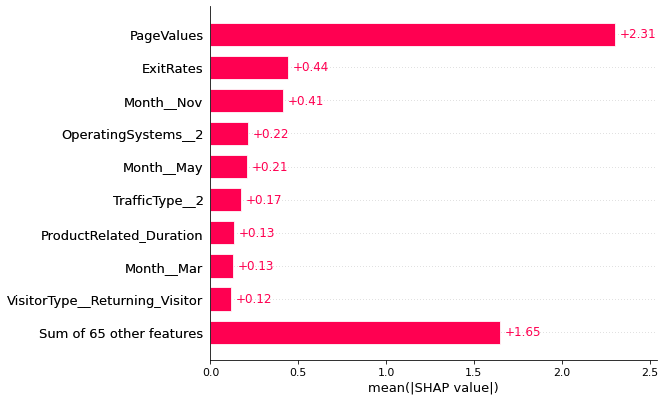

In [40]:
# Plot shap values
shap.plots.bar(shap_values)

In [51]:
# Plot coefficients of logistic regression model
fig = px.bar(coef_df[:10], x='coef', y='column', orientation='h')
fig.show()

From the above two plots, it can be observed that shap and the logistic regression model coefficients agree on page values to be the most important variable. The other feature that they are partially agreeing on is the duration for which visitor visits product related pages. Also, month of november seems to be also important for shopping and it makes sense since that is the period near holidays.

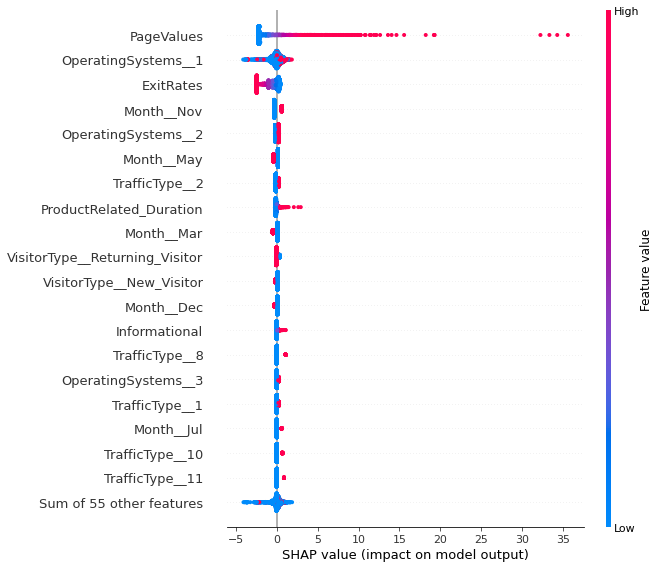

In [53]:
shap.plots.beeswarm(shap_values=shap_values, max_display=20)

Some high page values are prominently affecting the model. The higher the page value the higher the chance that the visitor will transact. For exit rates, though it is true that high value will not convert a visitor but low values may not convert her either. Customer spending huge amount of time on product related pages can convert the her into a transacting visitor, though the effect is not even comparable with the effect of page values. Also the customer visiting more number of informational pages may covert into a trasacting user. People shop the least in the month of may and shop the most in the month of november. Traffic type 8 is are the more likely to transact. This is even confirmed from the logitic regression coefficient as it is among the top 10 features affecting the model. Traffic type 10, 11 also contribute to the revenue. People using operating system 2 are more likely to transact. Though less amount of explanation is present from the author for the features such traffic type and operating system, no concrete interpretation for these features.

## Learnings

1. Feature selection methods were tried with generic univariate select but it did not improve the performance. Hence the idea to select features is dropped as these methods would reduce the explainability of the model.
2. Logistic regression hyperparameter tuning with grid search training on GPU is extremely fast.